In [ ]:
from collections import deque
import sys
import math
import numpy as np
from enum import Enum
import random
import networkx as nx
from tensorflow import keras
from tensorflow.compat.v1.keras.backend import set_session

import glob
import os
import sys

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla
 
from carla import ColorConverter as cc

import collections
import datetime
import logging
import re
import weakref
 
import cv2

import time
import PIL.Image
from io import BytesIO
import IPython.display
import ipywidgets as widgets

HEIGHT = 88
WIDTH = 200

import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)

)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
print('Task Done')

Task Done


Show images in jupyter

In [ ]:
class Xview(object):
    
    display_ids = {}
        
    @staticmethod     
    def showarray(a, prev_display_id=None, fmt='jpeg'):
        f = BytesIO()
        PIL.Image.fromarray(a).save(f, fmt)
        obj = IPython.display.Image(data=f.getvalue())
        if prev_display_id is not None:
            IPython.display.update_display(obj, display_id=prev_display_id)
            return prev_display_id
        else:
            return IPython.display.display(obj, display_id=True)
    
    @staticmethod
    def zoom(frame, scale_percent = 100):
        width = int(frame.shape[1] * scale_percent / 100)
        height = int(frame.shape[0] * scale_percent / 100)
        dsize = (width, height)
        output = cv2.resize(frame, dsize)
        return output
    
    @staticmethod
    def stick_together(a, b, axis=1):
        if axis == 1:
            h = min(a.shape[0], b.shape[0])
            r1 = h / a.shape[0]
            r2 = h / b.shape[0]
            a = cv2.resize(a, (int(r1 * a.shape[1]), int(r1 * a.shape[0])))
            b = cv2.resize(b, (int(r2 * b.shape[1]), int(r2 * b.shape[0])))
            return np.concatenate([a, b], 1)
        else:
            h = min(a.shape[1], b.shape[1])
            r1 = h / a.shape[1]
            r2 = h / b.shape[1]
            a = cv2.resize(a, (int(r1 * a.shape[1]), int(r1 * a.shape[0])))
            b = cv2.resize(b, (int(r2 * b.shape[1]), int(r2 * b.shape[0])))
            return np.concatenate([a, b], 0)
    
    @staticmethod
    def img_show2(name, frame_a, frame_b, scale=100):
        Xview.img_show(name, Xview.stick_together(frame_a, frame_b), scale)
        
    @staticmethod
    def img_show(name, frame, scale=100):
        t1 = time.time()    
        frame = Xview.zoom(frame)
        display_id = Xview.display_ids.get(name)
        if display_id is not None:
            Xview.showarray(frame, display_id)
        else:
            display_handle = Xview.showarray(frame)
            display_id = display_handle.display_id
            Xview.display_ids[name] = display_id
        t2 = time.time()
        return 1/(t2-t1)
    
print('Task Done')

Task Done


# Agent

<!-- ![image.png](attachment:410375bc-b5ff-4698-99bc-5aac4e5c6669.png) -->
<img src="attachment:410375bc-b5ff-4698-99bc-5aac4e5c6669.png"  width="40%" height="40%">


In [ ]:
import abc

class Agent(object):
    
    def __init__(self):
        self.__metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def run_step(self, measurements, sensor_data, directions, target):
        """
        Function to be redefined by an agent.
        :param The measurements like speed, the image data and a target
        :returns A carla Control object, with the steering/gas/brake for the agent
        """

class ModelAgent(Agent):
    def __init__(self, model_path):
        self.model = keras.models.load_model(model_path)
        print("model loaded")
    
    @staticmethod
    def process_image(image):
        raw_image = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        raw_image = np.reshape(raw_image, (HEIGHT, WIDTH, 4))
        processed_image = image[:, :, :3]
        print('image processed')
        return processed_image
        
    def run_step(self, measurements, sensor_data, directions, target):
        current_speed = measurements['speed']
        input = sensor_data.camera['rgb']/255
        
        input2 = sensor_data.camera['semantic']/255
        input3 = sensor_data.camera['depth']/255
        input = np.append(input ,input2, axis= 2)
        input = np.append(input ,input3, axis= 2)
        
    
        #[[steer, throttle]] = self.model.predict(np.array([input][0:2]))
        [[steer, throttle, brake]] = self.model.predict(np.array([input]))

        #IPython.display.display(f"Steer: {steer}\t Throttle: {throttle}\t Brake:{brake}")
        #IPython.display.display(f"Speed: {current_speed}\t throttle: {throttle}\t Brake:{brake}")
        control = carla.VehicleControl()
        Xview.img_show2('img-from-sensor', sensor_data.camera['depth'], sensor_data.camera['semantic'], 100)
        if current_speed > 15.0:
            control.throttle = 0.0
        else:
            control.throttle = throttle.item()    
        control.steer = steer.item()
        control.brake = brake.item()
        control.brake = 0
        
        if brake < 0.1:
            brake = 0.0

        if throttle > brake:
            brake = 0.0
            

        # We limit speed to 35 km/h to avoid
        if current_speed > 2.0:
            acc = 0.0
            
        control.hand_brake = 0
        control.reverse = 0
        
        return control
    
print('Task Done')

Task Done


# World

Object that represents the simulation. It is an abstract layer that contains methods to spawn actors, change weather, get current state and much more.

In [ ]:
def get_actor_display_name(actor, truncate=250):
    name = ' '.join(actor.type_id.replace('_', '.').title().split('.')[1:])
    return (name[:truncate - 1] + u'\u2026') if len(name) > truncate else name

class Sensors(object):
    def __init__(self):
        self.camera = dict()
        self.collision = None
        self.lane_invasion = None
        self.gnss = None
        self.imu = None
        
class World(object):
    
    restarted = False

    def __init__(self, client):
        self.client = client
        self.world = client.get_world()
        self._roles_names = ['ego', 'hero', 'hero1', 'hero2','hero3', 'hero4','hero5', 'hero6']
        self.actor_role_name = random.choice(self._roles_names)
        self._sensors = Sensors()
        self._measurements = dict()
        
        try:
            self.map = self.world.get_map()
        except RuntimeError as error:
            logging.error('RuntimeError: {}'.format(error))
            logging.error('  The server could not send the OpenDRIVE (.xodr) file:')
            logging.error('  Make sure it exists, has the same name of your town, and is correct.')
            sys.exit(1)
        self.player = None
        self.camera_manager = None
        self.collision_sensor = None
        self.lane_invasion_sensor = None
        self.gnss_sensor = None
        self.imu_sensor = None
        
        self._actor_filter = 'audi.tt'
        self._gamma = 2.2
        self.restart()

    def restart(self):
        self.player_max_speed = 1.589
        self.player_max_speed_fast = 3.713
        # Keep same camera config if the camera manager exists.
        cam_index = self.camera_manager.index if self.camera_manager is not None else 0
        cam_pos_index = self.camera_manager.transform_index if self.camera_manager is not None else 0
        # Get a random blueprint.
        blueprint = self.world.get_blueprint_library().find('vehicle.audi.tt')
        #blueprint = random.choice(self.world.get_blueprint_library().filter(self._actor_filter))
        blueprint.set_attribute('role_name', self.actor_role_name)
        if blueprint.has_attribute('color'):
            #color = random.choice(blueprint.get_attribute('color').recommended_values)
            color = blueprint.get_attribute('color').recommended_values[0]
            blueprint.set_attribute('color', color)
        if blueprint.has_attribute('driver_id'):
            driver_id = random.choice(blueprint.get_attribute('driver_id').recommended_values)
            blueprint.set_attribute('driver_id', driver_id)
        if blueprint.has_attribute('is_invincible'):
            blueprint.set_attribute('is_invincible', 'true')
        # set the max speed
        if blueprint.has_attribute('speed'):
            self.player_max_speed = float(blueprint.get_attribute('speed').recommended_values[1])
            self.player_max_speed_fast = float(blueprint.get_attribute('speed').recommended_values[2])
        else:
            print("No recommended values for 'speed' attribute")
        # Spawn the player.
        if self.player is not None:
            spawn_point = self.player.get_transform()
            spawn_point.location.z += 2.0
            spawn_point.rotation.roll = 0.0
            spawn_point.rotation.pitch = 0.0
            self.destroy()
            self.player = self.world.try_spawn_actor(blueprint, spawn_point)
        while self.player is None:
            if not self.map.get_spawn_points():
                print('There are no spawn points available in your map/town.')
                print('Please add some Vehicle Spawn Point to your UE4 scene.')
                sys.exit(1)
            spawn_points = self.map.get_spawn_points()
            spawn_point = spawn_points[6]
            #spawn_point = random.choice(spawn_points) if spawn_points else carla.Transform()
            
            self.player = self.world.try_spawn_actor(blueprint, spawn_point)

        cam_index = 0
        cam_pos_index = 1
        # Set up the sensors.
        self.collision_sensor = CollisionSensor(self.player)
        self.lane_invasion_sensor = LaneInvasionSensor(self.player)
        self.gnss_sensor = GnssSensor(self.player)
        self.imu_sensor = IMUSensor(self.player)
        self.camera_manager = CameraManager(self.player, self._gamma, WIDTH, HEIGHT)
        self.camera_manager.transform_index = cam_pos_index
        self.camera_manager.set_sensor(cam_index, notify=False)
        actor_type = get_actor_display_name(self.player)
        
    def render(self):
        self.camera_manager.render()
            
    def destroy_sensors(self):
        self.camera_manager.sensor.destroy()
        self.camera_manager.sensor = None
        self.camera_manager.index = None

    def destroy(self):
        actors = [
            self.camera_manager.sensor,
            self.player]
        for actor in actors:
            if actor is not None:
                actor.destroy()
    
    def get_sensors(self):
        self._sensors.camera.update({
            'rgb': self.camera_manager.surface,
            'semantic': self.camera_manager.surface_semantic,
            'depth': self.camera_manager.surface_depth
            })
        self._sensors.collision = self.collision_sensor
        self._sensors.lane_invasion = self.lane_invasion_sensor
        self._sensors.gnss = self.gnss_sensor
        self._sensors.imu = self.imu_sensor
        return self._sensors
    
    def _get_speed(self):
        vel = self.player.get_velocity()
        return 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)

    def get_measurements(self):
        self._measurements.update({
            'speed': self._get_speed()
            })
        return self._measurements

print('Task Done')

Task Done


# Sensors

https://carla.readthedocs.io/en/latest/ref_sensors/

In [ ]:
class CollisionSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self.history = []
        self._parent = parent_actor
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.collision')
        self.sensor = world.spawn_actor(bp, carla.Transform(), attach_to=self._parent)
        # We need to pass the lambda a weak reference to self to avoid circular
        # reference.
        weak_self = weakref.ref(self)
        self.sensor.listen(lambda event: CollisionSensor._on_collision(weak_self, event))

    def get_collision_history(self):
        history = collections.defaultdict(int)
        for frame, intensity in self.history:
            history[frame] += intensity
        return history

    @staticmethod
    def _on_collision(weak_self, event):
        self = weak_self()
        if not self:
            return
        actor_type = get_actor_display_name(event.other_actor)
        impulse = event.normal_impulse
        intensity = math.sqrt(impulse.x**2 + impulse.y**2 + impulse.z**2)
        self.history.append((event.frame, intensity))
        if len(self.history) > 4000:
            self.history.pop(0)
            
class LaneInvasionSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self._parent = parent_actor
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.lane_invasion')
        self.sensor = world.spawn_actor(bp, carla.Transform(), attach_to=self._parent)
        # We need to pass the lambda a weak reference to self to avoid circular
        # reference.
        weak_self = weakref.ref(self)
        self.sensor.listen(lambda event: LaneInvasionSensor._on_invasion(weak_self, event))

    @staticmethod
    def _on_invasion(weak_self, event):
        self = weak_self()
        if not self:
            return
        lane_types = set(x.type for x in event.crossed_lane_markings)
        text = ['%r' % str(x).split()[-1] for x in lane_types]

class GnssSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self._parent = parent_actor
        self.lat = 0.0
        self.lon = 0.0
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.gnss')
        self.sensor = world.spawn_actor(bp, carla.Transform(carla.Location(x=1.0, z=2.8)), attach_to=self._parent)
        # We need to pass the lambda a weak reference to self to avoid circular
        # reference.
        weak_self = weakref.ref(self)
        self.sensor.listen(lambda event: GnssSensor._on_gnss_event(weak_self, event))

    @staticmethod
    def _on_gnss_event(weak_self, event):
        self = weak_self()
        if not self:
            return
        self.lat = event.latitude
        self.lon = event.longitude

class IMUSensor(object):
    def __init__(self, parent_actor):
        self.sensor = None
        self._parent = parent_actor
        self.accelerometer = (0.0, 0.0, 0.0)
        self.gyroscope = (0.0, 0.0, 0.0)
        self.compass = 0.0
        world = self._parent.get_world()
        bp = world.get_blueprint_library().find('sensor.other.imu')
        self.sensor = world.spawn_actor(
            bp, carla.Transform(), attach_to=self._parent)
        # We need to pass the lambda a weak reference to self to avoid circular
        # reference.
        weak_self = weakref.ref(self)
        self.sensor.listen(
            lambda sensor_data: IMUSensor._IMU_callback(weak_self, sensor_data))

    @staticmethod
    def _IMU_callback(weak_self, sensor_data):
        self = weak_self()
        if not self:
            return
        limits = (-99.9, 99.9)
        self.accelerometer = (
            max(limits[0], min(limits[1], sensor_data.accelerometer.x)),
            max(limits[0], min(limits[1], sensor_data.accelerometer.y)),
            max(limits[0], min(limits[1], sensor_data.accelerometer.z)))
        self.gyroscope = (
            max(limits[0], min(limits[1], math.degrees(sensor_data.gyroscope.x))),
            max(limits[0], min(limits[1], math.degrees(sensor_data.gyroscope.y))),
            max(limits[0], min(limits[1], math.degrees(sensor_data.gyroscope.z))))
        self.compass = math.degrees(sensor_data.compass)
        
class CameraManager(object):
  
    def __init__(self, parent_actor, gamma_correction, width = WIDTH, height = HEIGHT):
        self.width = width
        self.height = height
        self.sensor = None
        self.surface = np.zeros(shape=(self.height, self.width, 3), dtype=np.uint8)
        self.surface_semantic = np.zeros(shape=(self.height, self.width, 3), dtype=np.uint8)
        self.surface_depth = np.zeros(shape=(self.height, self.width, 3), dtype=np.uint8)
        self.surface_view = np.zeros(shape=(self.height, self.width, 3), dtype=np.uint8)
        self._parent = parent_actor
        
        bound_y = 0.5 + self._parent.bounding_box.extent.y
        Attachment = carla.AttachmentType
        self._camera_transforms = [
            (carla.Transform(carla.Location(x=-5.5, z=2.5), carla.Rotation(pitch=8.0)), Attachment.SpringArm),
            (carla.Transform(carla.Location(x=1.6, z=1.7)), Attachment.Rigid),
            (carla.Transform(carla.Location(x=5.5, y=1.5, z=1.5)), Attachment.SpringArm),
            (carla.Transform(carla.Location(x=-8.0, z=6.0), carla.Rotation(pitch=6.0)), Attachment.SpringArm),
            (carla.Transform(carla.Location(x=-1, y=-bound_y, z=0.5)), Attachment.Rigid)]
        self.transform_index = 1
        self.sensors = [
            ['sensor.camera.rgb', cc.Raw, 'Camera RGB', {}],
            ['sensor.camera.depth', cc.Raw, 'Camera Depth (Raw)', {}],
            ['sensor.camera.depth', cc.Depth, 'Camera Depth (Gray Scale)', {}],
            ['sensor.camera.depth', cc.LogarithmicDepth, 'Camera Depth (Logarithmic Gray Scale)', {}],
            ['sensor.camera.semantic_segmentation', cc.Raw, 'Camera Semantic Segmentation (Raw)', {}],
            ['sensor.camera.semantic_segmentation', cc.CityScapesPalette,
                'Camera Semantic Segmentation (CityScapes Palette)', {}],
            ['sensor.lidar.ray_cast', None, 'Lidar (Ray-Cast)', {'range': '50'}],
            ['sensor.camera.dvs', cc.Raw, 'Dynamic Vision Sensor', {}],
            ['sensor.camera.rgb', cc.Raw, 'Camera RGB Distorted',
                {'lens_circle_multiplier': '3.0',
                'lens_circle_falloff': '3.0',
                'chromatic_aberration_intensity': '0.5',
                'chromatic_aberration_offset': '0'}]]
        world = self._parent.get_world()
        bp_library = world.get_blueprint_library()
        for item in self.sensors:
            bp = bp_library.find(item[0])
            if item[0].startswith('sensor.camera'):
                bp.set_attribute('image_size_x', str(self.width))
                bp.set_attribute('image_size_y', str(self.height))
                if bp.has_attribute('gamma'):
                    bp.set_attribute('gamma', str(gamma_correction))
                for attr_name, attr_value in item[3].items():
                    bp.set_attribute(attr_name, attr_value)
            elif item[0].startswith('sensor.lidar'):
                bp.set_attribute('range', '50')
            item.append(bp)
        self.index = None
        
    def set_sensor(self, index, notify=True, force_respawn=False):
        index = index % len(self.sensors)
        needs_respawn = True if self.index is None else \
            (force_respawn or (self.sensors[index][2] != self.sensors[self.index][2]))
        if needs_respawn:
            if self.sensor is not None:
                self.sensor.destroy()
                self.surface = None
                
            self.sensor_view = self._parent.get_world().spawn_actor(
                self.sensors[0][-1],
                self._camera_transforms[0][0],
                attach_to=self._parent,
                attachment_type=self._camera_transforms[0][1])
            
            self.sensor = self._parent.get_world().spawn_actor(
                self.sensors[0][-1],
                self._camera_transforms[self.transform_index][0],
                attach_to=self._parent,
                attachment_type=self._camera_transforms[self.transform_index][1])
                
            self.sensor_semantic = self._parent.get_world().spawn_actor(
                self.sensors[5][-1],
                self._camera_transforms[self.transform_index][0],
                attach_to=self._parent,
                attachment_type=self._camera_transforms[self.transform_index][1])
            
            self.sensor_depth = self._parent.get_world().spawn_actor(
                self.sensors[2][-1],
                self._camera_transforms[self.transform_index][0],
                attach_to=self._parent,
                attachment_type=self._camera_transforms[self.transform_index][1])
                
            # We need to pass the lambda a weak reference to self to avoid
            # circular reference.
            weak_self = weakref.ref(self)
            self.sensor.listen(lambda image: CameraManager._parse_sensor(weak_self, image, 0))
            self.sensor_view.listen(lambda image: CameraManager._parse_view(weak_self, image, 0))
            self.sensor_semantic.listen(lambda image: CameraManager._parse_semantic(weak_self, image, 5))
            self.sensor_depth.listen(lambda image: CameraManager._parse_depth(weak_self, image, 2))
        self.index = index
        
    def write(self, text, i, j, canvas, fontsize=0.4):
        rows = [x * (canvas.shape[0] // 10) for x in range(10+1)]
        cols = [x * (canvas.shape[1] // 9) for x in range(9+1)]
        cv2.putText(
                canvas, text, (cols[j], rows[i]),
                cv2.FONT_HERSHEY_SIMPLEX, fontsize, (255, 255, 255), 1)
        
    def render(self):
        if self.surface is not None and self.surface_view is not None:
            vel = self._parent.get_velocity()
            vel = 3.6 * math.sqrt(vel.x ** 2 + vel.y ** 2 + vel.z ** 2)
            self.write('Vel: ' + str(round(vel, 2)), 1, 0, self.surface_view, fontsize=0.8)
            Xview.img_show2('car-view', self.surface_view, self.surface, 100)
    
    @staticmethod
    def _parse_sensor(weak_self, image, sensor_index=0):
        self = weak_self()
        if not self:
            return
        self.surface = CameraManager._parse_image(weak_self, image, sensor_index)
        
    @staticmethod
    def _parse_view(weak_self, image, sensor_index=0):
        self = weak_self()
        if not self:
            return
        self.surface_view = CameraManager._parse_image(weak_self, image, sensor_index)
        
    @staticmethod
    def _parse_semantic(weak_self, image, sensor_index=0):
        self = weak_self()
        if not self:
            return
        self.surface_semantic = CameraManager._parse_image(weak_self, image, sensor_index)
    
    @staticmethod
    def _parse_depth(weak_self, image, sensor_index=0):
        self = weak_self()
        if not self:
            return
        self.surface_depth = CameraManager._parse_image(weak_self, image, sensor_index)
        
    @staticmethod
    def _parse_image(weak_self, image, sensor_index=0):
        self = weak_self()
        if not self:
            return
        image.convert(self.sensors[sensor_index][1])
        array = np.frombuffer(image.raw_data, dtype=np.dtype("uint8"))
        array = np.reshape(array, (image.height, image.width, 4))
        array = array[:, :, :3]
        array = array[:, :, ::-1]
        return array.copy() 
    
print('Task Done')

Task Done


# Client

Connects to the server which runs the simulation. Run by the user to ask for information or changes in the simulation.

INFO: Connecting...


No recommended values for 'speed' attribute
model loaded


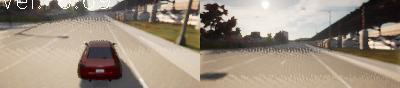

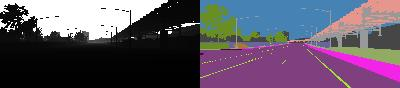

INFO: 
Quiting!


In [ ]:
log_level = logging.DEBUG
logging.basicConfig(format='%(levelname)s: %(message)s', level=log_level)
world = None

with tf.device('/gpu:0'):
    try:
        logging.info('Connecting...')                     
        client = carla.Client('localhost', 2000)
        client.set_timeout(10.0)
        world = World(client) 
        #world.player.set_autopilot(True)
        #agent = ForwardAgent()
        agent = ModelAgent("/MODELS/multi_camera_model.41.testing.h5")
      
        while True:
            world.render()
            sensor_data = world.get_sensors()
            measurements = world.get_measurements()
            
            control = agent.run_step(measurements, sensor_data, None, None)
            world.player.apply_control(control)

    except KeyboardInterrupt:
        logging.info('\nQuiting!')
        if world is not None:
            world.destroy()